In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utility import helpers

from gluonts.dataset.common import ListDataset

from gluonts.torch.model.patch_tst import PatchTSTEstimator
from gluonts.dataset.util import to_pandas


In [ ]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [3]:
def prepare_data_for_training(data: pd.DataFrame, prediction_length: int, start_date: pd.Timestamp):
    """
    Prepares the data for training; assumes that the input data is sorted by timestamp.

    Args:
        data (pd.DataFrame): A DataFrame containing time series data, sorted by timestamp.
        prediction_length (int): The number of time steps to be predicted in the future, used to trim the training data.
    
    Returns:
        Tuple[ListDataset, ListDataset]: A tuple containing two ListDataset objects:
            - The first is the training dataset, where the last prediction_length time steps are removed.
            - The second is the test dataset, which uses the entire dataset.
    """

    # drop timestamp and instance_id
    # transpose to have timestamps as columns
    data_np = data.drop({'timestamp', 'instance_id'}, axis=1).to_numpy().T

    # Convert timestamp index to PeriodIndex (assuming hourly frequency)
    start = pd.Period(start_date, freq="1h")

    # train dataset: 
    # Cut the last window of length "prediction_length".
    # Add "target" and "start" fields.
    # Convert to GluonTs ListDataset: A ListDataset is a dataset backed directly by list of dictionaries which must
    # have keys 'start' and 'target'. Each Dictionary corresponds to a univariate time series.

    train_ds = ListDataset(
        [{"target": x, "start": start} for x in data_np[:,:-prediction_length]], 
        freq="1h")
    train_ds

    # test dataset: 
    # Use the whole dataset
    # Add "target" and "start" fields
    test_ds = ListDataset(
        [{"target": x, "start": start} for x in data_np],
        freq="1h")

    return train_ds, test_ds

In [5]:
def visualize_data_gluonts(train_series, test_series):
    '''Visualizes the time series and test cutoff

    Args:
        train_series (ListDataset)
        test_series (ListDataset)
    '''

    # Number of series in the dataset
    n_series = len(test_series)

    # Create subplots with one row and n_series columns
    fig, axes = plt.subplots(n_series, 1, figsize=(10, 4 * n_series))

    titels = ['query_count', 'runtime', 'bytes_scanned']
    # Loop through each item in the ListDataset and plot it in a separate subplot
    for i, item in enumerate(zip(train_series, test_series)):
        train_series_pd = to_pandas(item[0])
        test_series_pd = to_pandas(item[1])
        test_series_pd.plot(ax=axes[i], title=titels[i], label='entire series')
        axes[i].axvline(train_series_pd.index[-1], color="r", linestyle='--', label='end of train series')
        # Add legend to each subplot
        axes[i].legend()
        axes[i].grid(which="both")
    plt.tight_layout()
    plt.show()

In [6]:
# load data
datamanager = helpers.DataManager('provisioned', 97)
data = datamanager.load_data()


# check the timestamps
print(data['timestamp'].iloc[0])

print(data['timestamp'].iloc[-1])

diff = data['timestamp'].iloc[-1] - data['timestamp'].iloc[0]
print(diff.total_seconds() / 3600 + 1)
print(len(data))



2024-03-01 00:00:00
2024-05-30 23:00:00
2184.0
2184


c:\Users\reese\OneDrive\Desktop\UTN\ML_DE_project\.mlproject2\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


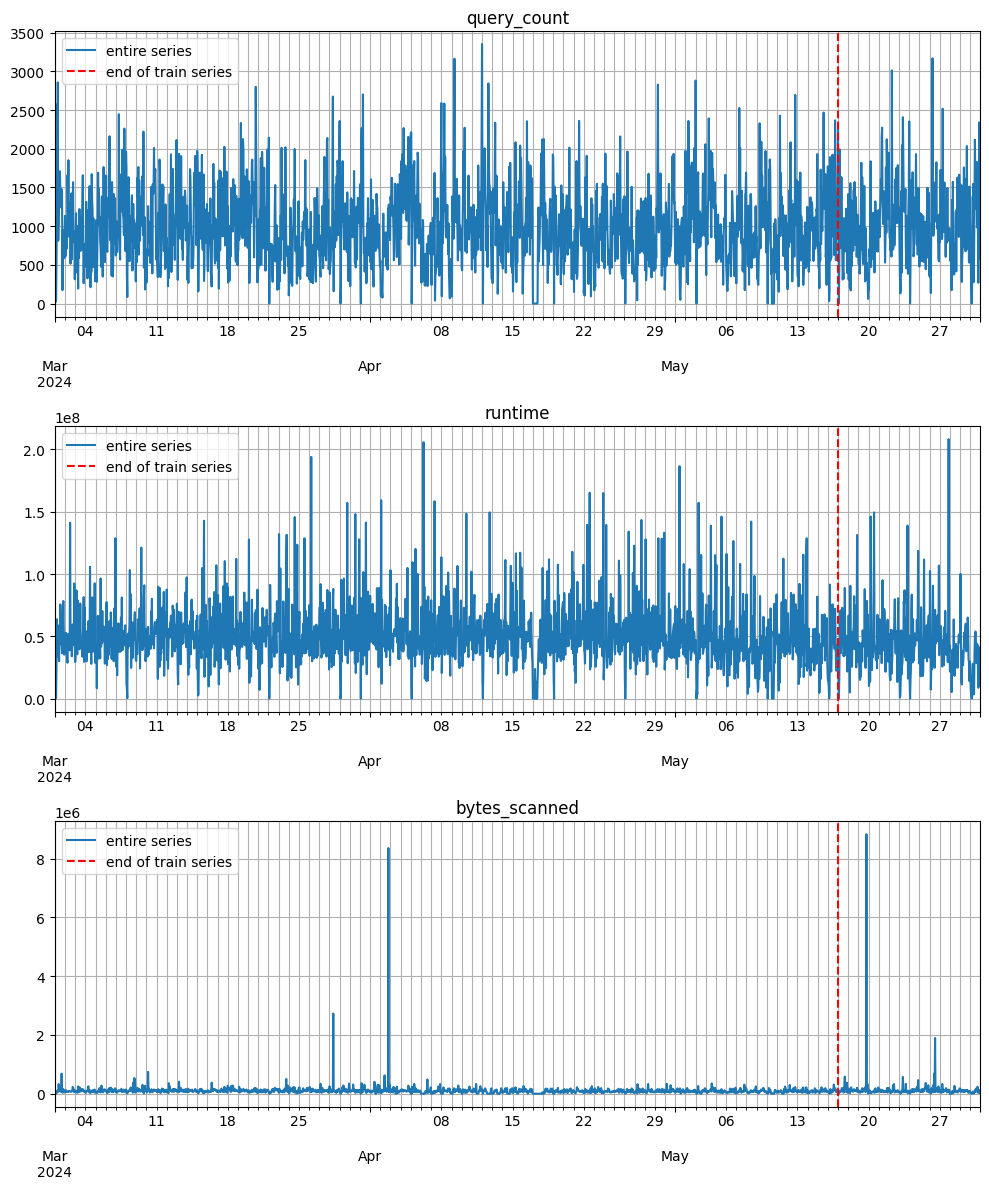

In [7]:
# prepare training data in gluonts format
start_date = pd.to_datetime('2024-03-01')
prediction_length = 24*2*7

train_ds, test_ds = prepare_data_for_training(data, prediction_length, start_date)
visualize_data_gluonts(train_ds, test_ds)


In [125]:
print(
    f"Length of forecasting window in test dataset: {len(to_pandas(next(iter(test_ds)))) - len(to_pandas(next(iter(train_ds))))}"
)
print(24*2*7)

Length of forecasting window in test dataset: 336
336


In [9]:
# instance normalization
# train
# predict

# prediction length two weeks
prediction_length = 24 * 7 * 2
# Number of time steps prior to prediction time that the model takes as inputs = lookback window
context_length = 10 * prediction_length
# patch 24 hours, with 12 hours stride
patch_len = 24
stride = 12
# Dimensionality of the transformer layers = embedding dimension
# kept small due to recommendation in paper
d_model = 16 # 128
# Number of attention heads in the Transformer encoder,  must divide d_model
nhead = 4
# Dimension of the feed-forward layer in the Transformer encoder
dim_feedforward = 128 #256
# Dropout probability in the Transformer encoder
dropout = 0.2
# Activation function in the Transformer encoder
activation = 'gelu'
# Number of encoder layers
num_encoder_layers = 3
# learning rate
lr = 1e-3
# Weight decay regularization parameter 
weight_decay = 1e-8
# batch size
batch_size = 32
# Number of batches to be processed in each training epoch
#num_batches_per_epoch = 50

estimator = PatchTSTEstimator(
    prediction_length = prediction_length,
    context_length = context_length,
    patch_len = patch_len,
    stride = stride,
    d_model = d_model,
    nhead = nhead,
    dim_feedforward = dim_feedforward,
    dropout = dropout,
    activation = activation,
    num_encoder_layers = num_encoder_layers,
    lr = lr,
    weight_decay = weight_decay,
    batch_size = batch_size,
    #num_batches_per_epoch = num_batches_per_epoch,
    trainer_kwargs = {'max_epochs': 5} # limit training epochs
)

In [27]:
train_ds[0]

{'target': array([2207., 2583.,   20., ..., 1439.,  905., 1394.], dtype=float32),
 'start': Period('2024-03-01 00:00', 'h')}

In [30]:
predictor = estimator.train([train_ds[0]])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PatchTSTModel | 24.1 M | train
------------------------------------------------
24.1 M    Trainable params
4.5 K     Non-trainable params
24.1 M    Total params
96.444    Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 9.34341 (best 9.34341), saving model to 'c:\\Users\\reese\\OneDrive\\Desktop\\UTN\\ML_DE_project\\repo\\g8\\lightning_logs\\version_6\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.00537 (best 8.00537), saving model to 'c:\\Users\\reese\\OneDrive\\Desktop\\UTN\\ML_DE_project\\repo\\g8\\lightning_logs\\version_6\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.74103 (best 7.74103), saving model to 'c:\\Users\\reese\\OneDrive\\Desktop\\UTN\\ML_DE_project\\repo\\g8\\lightning_logs\\version_6\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.70636 (best 7.70636), saving model to 'c:\\Users\\reese\\OneDrive\\Desktop\\UTN\\ML_DE_project\\repo\\g8\\lightning_logs\\version_6\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.68770 (best 7.68770), saving model to 'c:\\Us

In [59]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [61]:
forecasts = list(forecast_it)
tss = list(ts_it)
forecasts


[]

In [14]:
# Convert query_count to numpy array
query_counts = data["query_count"].to_numpy()

# Convert timestamp index to PeriodIndex (assuming hourly frequency)
start = pd.Period('2024-03-01', freq="1h")

# Display results
print("Numpy Array:\n", query_counts)
print("\nPeriodIndex:\n", start)


Numpy Array:
 [2207. 2583.   20. ... 2341.  745.  579.]

PeriodIndex:
 2024-03-01 00:00


In [15]:
from gluonts.dataset.common import ListDataset

freq = "1h"
t = [{"target": x, "start": start} for x in query_counts]
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": query_counts[1000:-10], "start": start}],
    freq=freq,
)

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": query_counts[1000:-10], "start": start}], 
    freq=freq
)


In [ ]:
from gluonts.dataset.util import to_pandas

entry = next(iter(train_ds))

train_series = to_pandas(entry) # pandas.Series object

train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

{'target': array([ 886., 1012., 1122., ..., 2117., 1529., 1224.], dtype=float32),
 'start': Period('2024-03-01 00:00', 'h')}

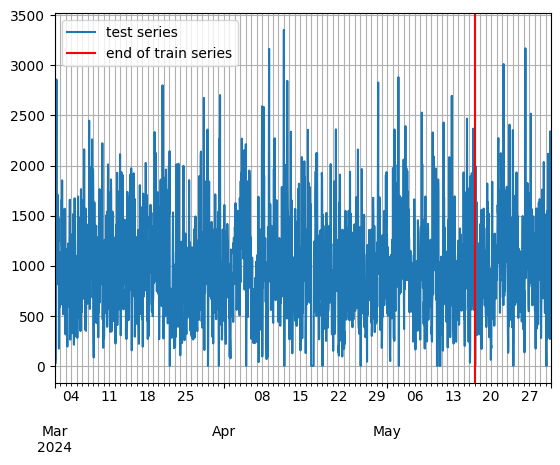

In [85]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()


In [75]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=90,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [76]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:00<00:00, 133.21it/s, epoch=5/5, avg_epoch_loss=8.54]


In [11]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [1]:
forecasts = list(forecast_it)
tss = list(ts_it)

NameError: name 'forecast_it' is not defined

In [108]:
# first entry of the time series list
ts_entry = tss[0]
ts_entry

,0
2024-03-01 00:00,10917.0
2024-03-01 01:00,10032.0
2024-03-01 02:00,9968.0
2024-03-01 03:00,11411.0
2024-03-01 04:00,11382.0
...,...
2024-03-17 11:00,10916.0
2024-03-17 12:00,8378.0
2024-03-17 13:00,9777.0
2024-03-17 14:00,10644.0


In [80]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([10917., 10032.,  9968., 11411., 11382.], dtype=float32)

In [81]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [82]:
# first 5 values
dataset_test_entry["target"][:5]

array([10917., 10032.,  9968., 11411., 11382.], dtype=float32)

In [83]:
# first entry of the forecast list
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

# print(f"Mean of the future window:\n {forecast_entry.mean}")
# print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Number of sample paths: 100
Dimension of samples: (100, 90)
Start date of the forecast window: 2024-03-13 22:00
Frequency of the time series: <Hour>


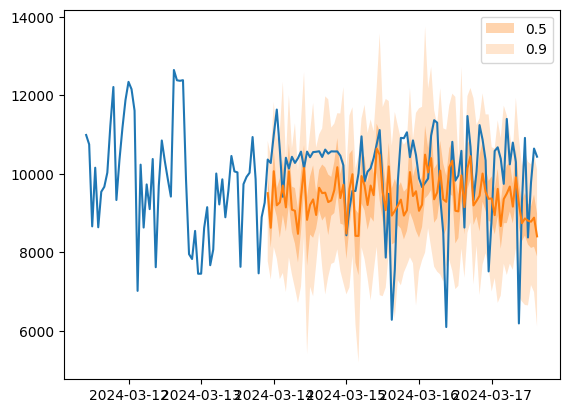

In [113]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [133]:
from gluonts.evaluation import Evaluator
import json

In [126]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 1it [00:00, 36.24it/s]


In [134]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 1997072.5333333334,
    "abs_error": 106434.75,
    "abs_target_sum": 903703.0,
    "abs_target_mean": 10041.144444444444,
    "seasonal_error": 881.4855967078189,
    "MASE": 1.3416082324545637,
    "MAPE": 0.12186838785807291,
    "sMAPE": 0.12395411597357855,
    "MSIS": 9.337746322379449,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 51123.61796875,
    "Coverage[0.1]": 0.08888888888888889,
    "QuantileLoss[0.5]": 106434.7421875,
    "Coverage[0.5]": 0.17777777777777778,
    "QuantileLoss[0.9]": 52228.125195312496,
    "Coverage[0.9]": 0.5555555555555556,
    "RMSE": 1413.1781675830312,
    "NRMSE": 0.1407387549697996,
    "ND": 0.1177762494978992,
    "wQuantileLoss[0.1]": 0.056571260656155836,
    "wQuantileLoss[0.5]": 0.11777624085291295,
    "wQuantileLoss[0.9]": 0.05779346222742704,
    "mean_absolute_QuantileLoss": 69928.82845052083,
    "mean_wQuantileLoss": 0.07738032124549861,
    "MAE_Coverage": 0.2851851851851852,
    "OWA": NaN
}


In [130]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2024-03-22 06:00,1.997073e+06,106434.75,903703.0,10041.144444,881.485597,1.341608,0.121868,0.123954,0.0,0.117776,9.337746,51123.617969,0.088889,106434.742188,0.177778,52228.125195,0.555556


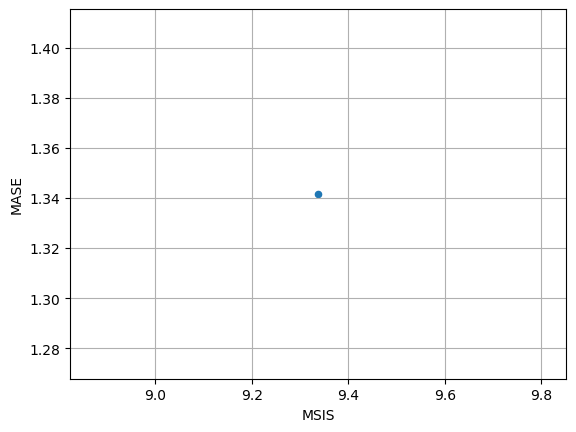

In [131]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()